In [3]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

Standardization = z-score normalization, 元データの平均を0に、標準偏差が1に変換する。


$
x_{new}^{i}=\frac{x^i-\mu}{\sigma}
$

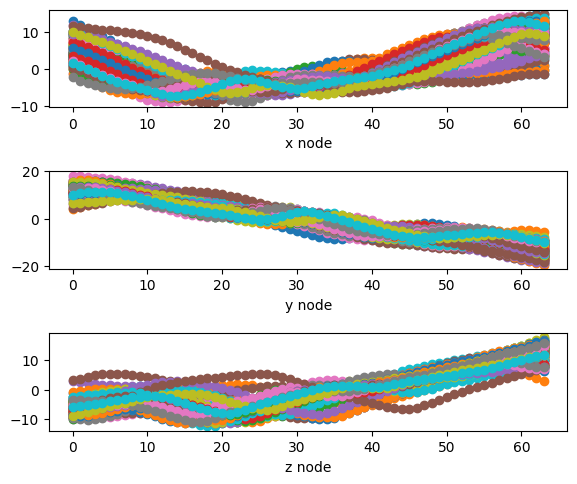

In [33]:
files = (glob.glob(".\\scaling\\resamp_attr_ascii\\*.vtk"))

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(files[i])
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(pts[i])), pts[i,:,0])
    ax2.scatter(range(len(pts[i])), pts[i,:,1])
    ax3.scatter(range(len(pts[i])), pts[i,:,2])
plt.savefig("experiment_note/img/og_coord.png")

0
[1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0
 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0]


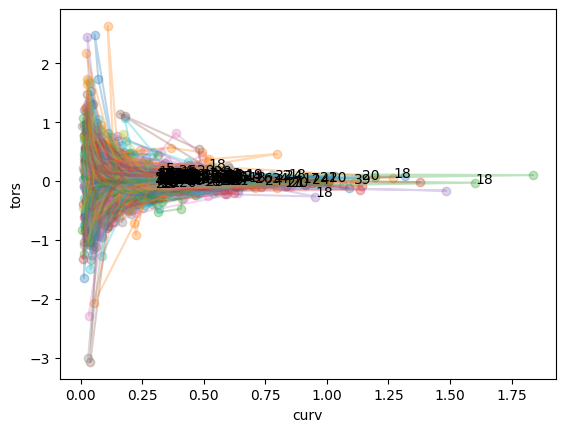

In [25]:
torsion_inverse = []

###################################################
#    torsion_inverse: [vessel_idx, node1, node2]  #
#    t_inverse:[0:non-inversed,                   #
#                1:inversed;                      #
#                location:idx]                    #
###################################################

filtered = 0
for i in range(len(pts)): 
    #if max(curvs[i])<1.0 and max(abs(torss[i]))<1.0:
    if 1:
        plt.scatter(curvs[i], torss[i], label="{:0=3}".format(i), alpha=0.3)
        plt.plot(curvs[i], torss[i], alpha=0.3)
        for j in range(1, len(curvs[i])-1 ):
            if curvs[i][j] > 0.3 :
                if torss[i][j]*torss[i][j+1]<0:
                    torsion_inverse.append([i, j, j+1])
                    plt.text(x=curvs[i][j], y=torss[i][j], s=j)
                elif torss[i][j-1]*torss[i][j]<0 and [i, j-1, j] not in torsion_inverse:
                    torsion_inverse.append([i, j-1, j])
                    plt.text(x=curvs[i][j], y=torss[i][j], s=j)
    else:
        filtered+=1

print (filtered)

torsion_inverse = np.array(torsion_inverse)
plt.xlabel("curv")
plt.ylabel("tors")
# plt.title("PC2")
# plt.legend()

# print (torsion_inverse)

################################################
#         分成有inverse和无inverse　　　　　　　 #
################################################

t_inverse = np.zeros_like(range(len(files)))
# print (torsion_inverse[:,0])

t_inverse[torsion_inverse[:,0]]=1
print (t_inverse)

## 参照文献[1]的方法计算Ec和Et

[1] Objective characterization of the course of the parasellar internal carotid artery using mathematical tools

- 计算出的值和文献给出的差异很大

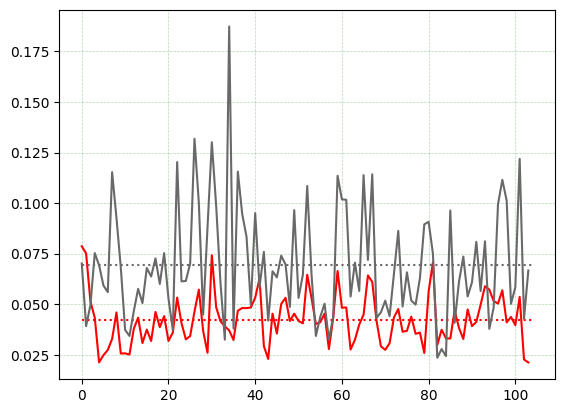

In [26]:
def Energy_curvtors(curv, pt):
    # c_length = measure_length(pts)*measure_length(pts)
    c_length = 1
    c_sum = 0
    for i in range(len(curv)):
        c_sum+=min(1, (curv[i])*(curv[i]))
    # print (c_sum/len(curv))
    return c_length*(c_sum/len(curv))

curv_energe = []
tors_energe = []
for i in range(len(files)):
    curv_energe.append(Energy_curvtors(curvs[i][2:-2], pts[i][2:-2]))
    tors_energe.append(Energy_curvtors(torss[i][2:-2], pts[i][2:-2]))

plt.plot(curv_energe, color="red")
plt.plot([0,104],[np.mean(curv_energe), np.mean(curv_energe)], color="red", linestyle=":")
plt.plot(tors_energe,color="dimgray")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.plot([0,104],[np.mean(tors_energe), np.mean(tors_energe)], color="dimgray", linestyle=":")

In [27]:
from scipy.spatial.transform import Rotation
# from skopt import gp_minimize
from scipy.optimize import minimize

print (Rotation.random().as_matrix().shape)

curve = pts[16]

def distance_curve2yz(curve):
    d = 0
    for i in range(len(curve)):
        # p_on_yx = (0, curve[i][1],curve[i][2])
        d = d + abs(curve[i,0])
    return d


def rotate_curve(curve, quat):
    rot = Rotation.from_quat(quat)
    return (rot.apply(curve))

def opt_distance(quat):
    c = curve
    return distance_curve2yz(rotate_curve(c, quat))

res = minimize(opt_distance, x0=Rotation.random().as_quat(), method='Nelder-Mead')
print (res.x)
#print (res)

new_curve = rotate_curve(curve, res.x)

(3, 3)
[ 0.23507314 -0.44969946  0.69519789 -0.43899124]


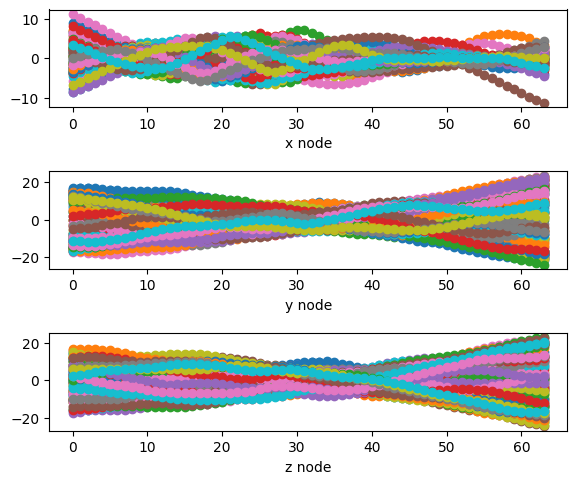

In [32]:
new_pts = []

for i in range(len(pts)):
    curve = pts[i]
    res = minimize(opt_distance, x0=Rotation.random().as_quat(), method='Nelder-Mead')
    # print (res.x)
    #print (res)
    new_curve = rotate_curve(curve, res.x)
    new_pts.append(new_curve)

new_pts = np.array(new_pts)


fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(new_pts[i])), new_pts[i,:,0])
    ax2.scatter(range(len(new_pts[i])), new_pts[i,:,1])
    ax3.scatter(range(len(new_pts[i])), new_pts[i,:,2])
plt.savefig("experiment_note/img/rot_coord.png")

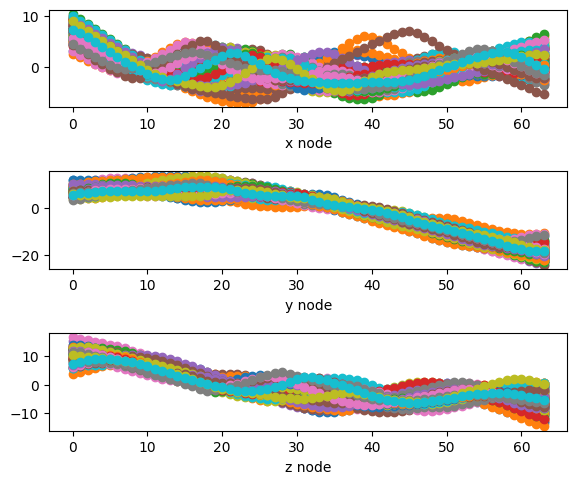

In [31]:
from procrustes import rotational

v1 = 0
v2 = 0
aligned_pts = []
aligned_pts.append(new_pts[0,:,:])
for i in range(1, len(new_pts)):
    result_rot = rotational(new_pts[i,:,:], new_pts[0,:,:], translate=False, scale=False)
    # aligned_pts.append(result_rot.new_a)
    aligned_pts.append(np.dot(result_rot.new_a, result_rot.t))
    scalarAttribute= [['MaximumInscribedSphereRadius', 'float', r[i]]]
    # makeVtkFile(savePath = "D:\\!BraVa_src\\src\\ModeDecomposition\\rot_alignment\\"+files[i].split("\\")[-1],
    #             coords = np.dot(result_rot.new_a, result_rot.t),
    #             scalarAttributes=scalarAttribute,
    #             fieldAttributes=[] )



aligned_pts = np.array(aligned_pts)

# fig = plt.figure(figsize=(6, 5))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(100):
#     ax.plot(aligned_pts[i,:,0], aligned_pts[i,:,1], aligned_pts[i,:,2])
# ax.view_init(v1, v2)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,0])
    ax2.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,1])
    ax3.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,2])
plt.savefig("experiment_note/img/procrustes_coord.png")

## 经过paraview输出确认（.\\rotated_cluster\\）旋转后方向一致
color represents node idx, not Radius

![](./experiment_note/alignedPts.png)

In [14]:
from datetime import datetime
import time
SAVE_ALIGNED_PTS = 0

if SAVE_ALIGNED_PTS == 1:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.save(file=".\\centroid_aligned_pts_{}.npy".format(time_str),
                arr=aligned_pts)

(104, 192)


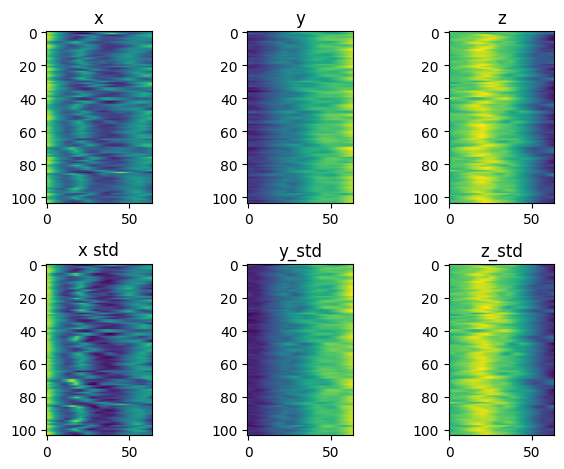

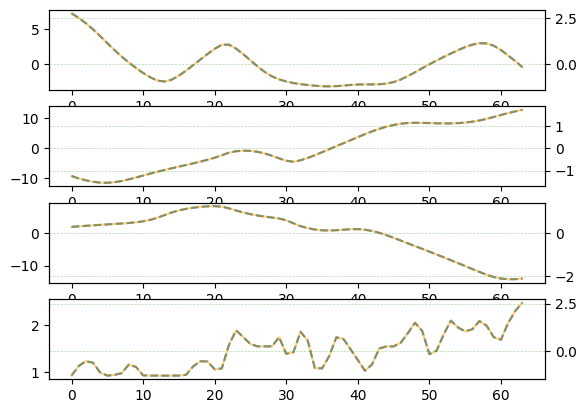

In [15]:
# 標準化

x = aligned_pts[:,:,0]
y = aligned_pts[:,:,1]
z = aligned_pts[:,:,2]

X_std = zscore(x,axis=1)
Y_std = zscore(y,axis=1)
Z_std = zscore(z,axis=1)
R_std = zscore(r,axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(x)
ax2.imshow(y)
ax3.imshow(z)
ax4.imshow(X_std)
ax5.imshow(Y_std)
ax6.imshow(Z_std)

ax1.set_title("x")
ax2.set_title("y")
ax3.set_title("z")
ax4.set_title("x std")
ax5.set_title("y_std")
ax6.set_title("z_std")
plt.tight_layout()

# quad_std = np.append(X_std, np.append(Y_std,np.append(Z_std,R_std,axis=1),axis=1),axis=1)
quad_std = np.append(X_std, np.append(Y_std,Z_std,axis=1),axis=1)
# quad_std = np.append(X_std,Z_std,axis=1)
print (quad_std.shape)



i=99

fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.plot(range(len(aligned_pts[i])), aligned_pts[i][:,0],linestyle="--")
ax1 = ax1.twinx()
ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax1.plot(range(len(X_std[i])), X_std[i],alpha=0.5, color="orange")
ax2.plot(range(len(aligned_pts[i])), aligned_pts[i][:,1],linestyle="--")
ax2 = ax2.twinx()
ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax2.plot(range(len(Y_std[i])), Y_std[i],alpha=0.5, color="orange")
ax3.plot(range(len(aligned_pts[i])), aligned_pts[i][:,2],linestyle="--")
ax3 = ax3.twinx()
ax3.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax3.plot(range(len(Z_std[i])), Z_std[i],alpha=0.5, color="orange")
ax4.plot(range(len(r[i])), r[i],linestyle="--")
ax4 = ax4.twinx()
ax4.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax4.plot(range(len(R_std[i])), R_std[i],alpha=0.5, color="orange")

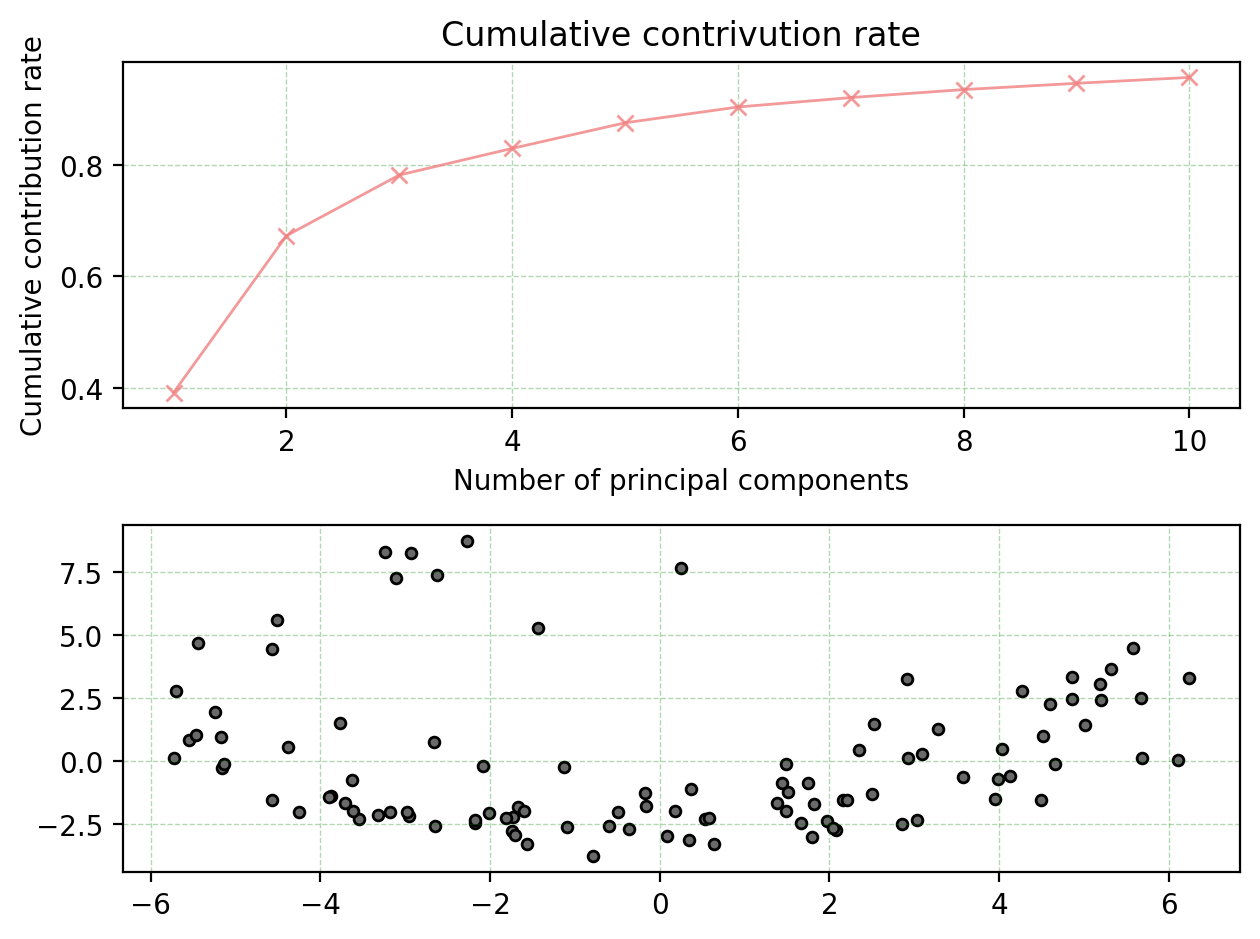

In [16]:
CROSS_VALID = 0

fig = plt.figure(dpi=200)
ax = fig.add_subplot(211)
pca = PCA(n_components=10)
result = pca.fit_transform(quad_std)
cumsum = list(np.cumsum(pca.explained_variance_ratio_))
ax.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1, color='lightcoral')
#ax.set_xticks([])
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative contribution rate")
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
ax.set_title("Cumulative contrivution rate")
ax.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)

ax2 = fig.add_subplot(212)

ax2.scatter(result[:,0],result[:,1],
            color = "dimgray", 
            alpha=1, 
            edgecolors="black", 
            linewidths=1, s=15)
ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)

plt.tight_layout()

### PC1支配了什么？？？
在y=0的线附近取点看

10
[[-4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


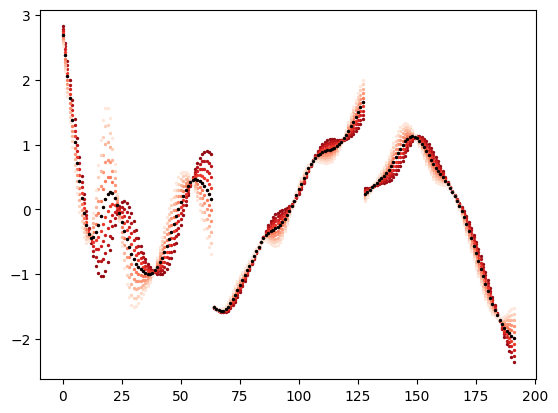

In [17]:
synthetic = np.zeros_like((result[:10,:]))
print (synthetic.shape[1])
for i in range(synthetic.shape[1]):
    synthetic[i][0] = i-4
print (synthetic)

syn = pca.inverse_transform(synthetic)
# print (syn.shape)

colorpalette=np.array(sns.color_palette(palette="Reds_r", n_colors=syn.shape[0]))
colordict = {}
for i in range(syn.shape[0]):
    colordict[i]=colorpalette[i]

#print (quad_std.shape)
for i in range(syn.shape[0]):
    if i != 0:
        plt.scatter(range(len(syn[i])), syn[i],color = colordict[i],s =2)
    else :
        plt.scatter(range(len(syn[i])), syn[i],color = colordict[i],s =2)

plt.scatter(range(len(syn[i])), pca.mean_,color="black",s =2)

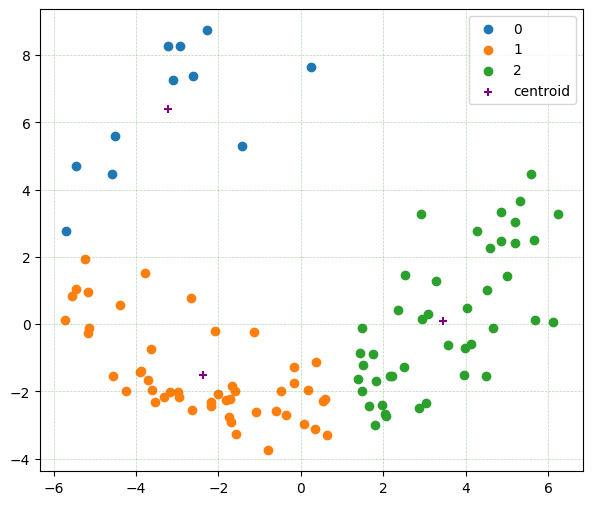

In [18]:
from sklearn.cluster import KMeans
from scipy import optimize
from math import sqrt


#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(result)
 
#Getting unique labels
u_labels = np.unique(label)

# display (label)
# display (u_labels)

#plotting the results:
plt.figure(figsize=(7,6))
for i in u_labels:
    plt.scatter(result[label == i , 0] , result[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.legend()
# plt.savefig('cluster.png')
plt.show()

# 在z上单调增加，且PC浮动小

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


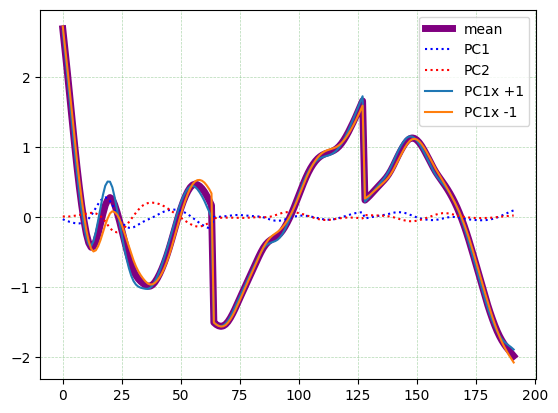

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pca.mean_, color = "purple", linewidth=5, label="mean")

ax.plot(pca.components_[0], color = "blue", linestyle=":", label="PC1")
# ax.plot(pca.inverse_transform(pca.components_[0]))
ax.plot(pca.components_[1], color = "red", linestyle=":", label="PC2")
# ax.plot(pca.mean_, color= "dimgray")


# 一个“一倍PC1"形状
temp = np.zeros((10))
temp[0] = 1
print (temp)
ax.plot(pca.inverse_transform(temp), label="PC1x +1")
temp[0] = -1
ax.plot(pca.inverse_transform(temp), label="PC1x -1")

#ax.bar(96,bottom = -2, height = 4, width=64,alpha=0.3, color="dimgray")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.legend()

# 移除Y, Z轴后pca降维结果微变，kmeans clustering结果没变

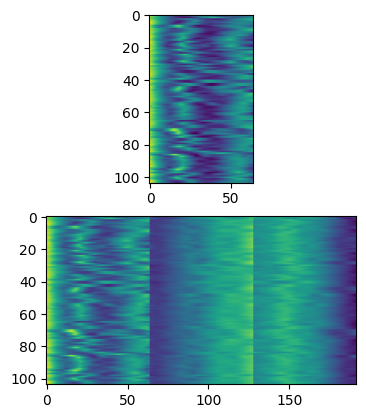

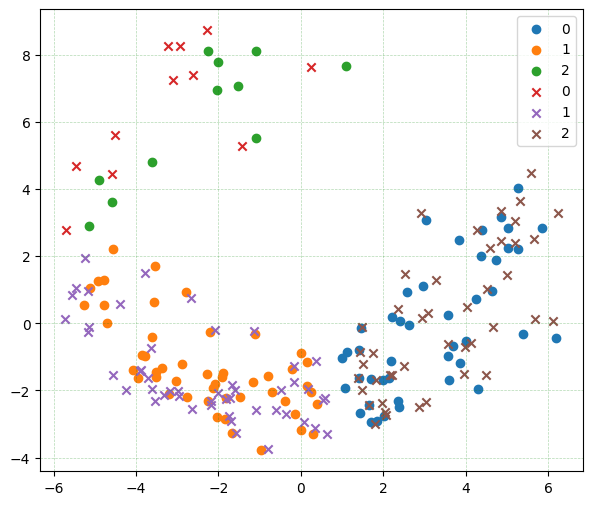

In [50]:
# tw_std  = np.append(quad_std[:,:64],quad_std[:,128:],axis=1)
# tw_std = quad_std[:,:128]
tw_std = quad_std[:,:64]

fig = plt.figure()
ax1= fig.add_subplot(211)
ax1.imshow(tw_std)
ax2 = fig.add_subplot(212)
ax2.imshow(quad_std)


tw_pca = PCA(n_components=10)

tw_result = tw_pca.fit_transform(tw_std)


#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
tw_label = kmeans.fit_predict(tw_result)
 
#Getting unique labels
tw_u_labels = np.unique(tw_label)

# display (label)
# display (u_labels)

#plotting the results:
plt.figure(figsize=(7,6))
for i in tw_u_labels:
    plt.scatter(tw_result[tw_label == i , 0] , tw_result[tw_label == i , 1] , label = i)
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')

for i in u_labels:
    plt.scatter(result[label == i , 0] , result[label == i , 1] , label = i , marker="x")
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.legend()
plt.savefig("experiment_note/img/tw_vs_tri.png")
plt.show()

# torsion是否反转未被检出

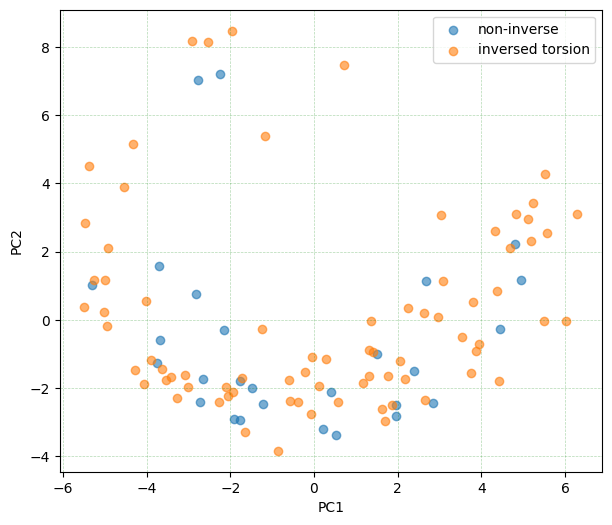

In [45]:
plt.figure(figsize=(7,6))
for i in [0,1]: # t_inverse
    if i == 0:
        lbl = "non-inverse"
    else:
        lbl = "inversed torsion"
    plt.scatter(tw_result[t_inverse == i , 0] , tw_result[t_inverse == i , 1] , label = lbl, alpha=0.6)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.show()


## 求Synthetic vessel的形状参数

### 在圆周上按角度取点（需要先拟合圆周）
### 固定其他PC，取极值(需要boxplot)
- 这个方法的一个潜在问题是**复原出来的间隔可能完全不是1mm**
    - 可能的关键字：elastic

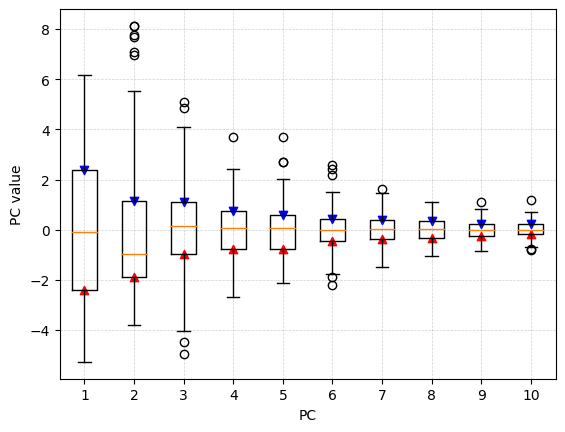

In [51]:
ax = plt.boxplot(tw_result)
plt.xlabel("PC")
plt.ylabel("PC value")
q1s=[]
q3s=[]

for i in range(tw_result.shape[1]):
    plt.scatter(i+1,np.quantile(a=tw_result[:,i],q=0.25),marker="^", color="red")
    plt.scatter(i+1,np.quantile(a=tw_result[:,i],q=0.75),marker="v", color="blue")
    q1s.append(np.quantile(a=tw_result[:,i],q=0.25))
    q3s.append(np.quantile(a=tw_result[:,i],q=0.75))
plt.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.savefig("experiment_note/img/boxplot.png")

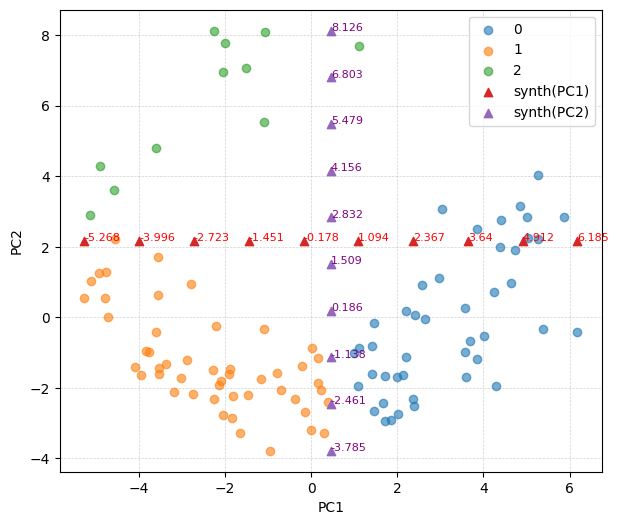

In [52]:
synthetic_1 = np.zeros_like((tw_result[:10,:]))
synthetic_2 = np.zeros_like((tw_result[:10,:]))

synthetic_1[:,0] = np.linspace(min(tw_result[:,0]), max(tw_result[:,0]), 10)
synthetic_1[:,1] = (min(tw_result[:,1])+max(tw_result[:,1]))/2.0

synthetic_2[:,1] = np.linspace(min(tw_result[:,1]), max(tw_result[:,1]), 10)
synthetic_2[:,0] = (min(tw_result[:,0])+max(tw_result[:,0]))/2.0

# print (synthetic_1)

#plotting the results:
plt.figure(figsize=(7,6))
for i in tw_u_labels:
    plt.scatter(tw_result[tw_label == i , 0] , tw_result[tw_label == i , 1] , label = i, alpha=0.6)
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
plt.scatter(synthetic_1[:,0], synthetic_1[:,1], marker="^", label="synth(PC1)")
plt.scatter(synthetic_2[:,0], synthetic_2[:,1], marker="^", label="synth(PC2)")

for i in range(len(synthetic_1)):
    plt.text(x=synthetic_1[i,0], y=synthetic_1[i,1], s="{}".format(round(synthetic_1[i,0], 3)), size=8, color="red")
    plt.text(x=synthetic_2[i,0], y=synthetic_2[i,1], s="{}".format(round(synthetic_2[i,1], 3)), size=8, color="purple")

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.show()


In [58]:
SAVE_SYN = 1

##############################
#  Z-geometry (mean)を求める  #
##############################
Z_geom = np.mean(Z_std, axis=0)
Y_geom = np.mean(Y_std, axis=0)

syn_1 = tw_pca.inverse_transform(synthetic_1)
print (syn_1.shape)
for i in range(syn_1.shape[0]):
    coords = [syn_1[i][:64], Y_geom, Z_geom]
    coords = np.array(coords).T
    coords = (64.0/measure_length(coords))*coords
    scalarAttribute= [['MaximumInscribedSphereRadius', 'float', np.mean(r,axis=1)]]
    if SAVE_SYN ==1 :
        makeVtkFile(savePath="D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\PC1\\PC1_{:0=3}_{}.vtk".format(i,round(synthetic_1[i,0],3)),
                    coords=coords,
                    scalarAttributes=[],
                    fieldAttributes=[])

syn_2 = tw_pca.inverse_transform(synthetic_2)
print (syn_2.shape)
for i in range(syn_2.shape[0]):
    coords = [syn_2[i][:64], Y_geom, Z_geom]
    coords = np.array(coords).T
    coords = (64.0/measure_length(coords))*coords
    scalarAttribute= [['MaximumInscribedSphereRadius', 'float', np.mean(r,axis=1)]]
    if SAVE_SYN ==1 :
        makeVtkFile(savePath="D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\PC2\\PC2_{:0=3}_{}.vtk".format(i,round(synthetic_2[i,1],3)),
                    coords=coords,
                    scalarAttributes=[],
                    fieldAttributes=[])
    

(10, 64)
(10, 64)


In [63]:
pca_mean = np.array([tw_pca.mean_, Y_geom, Z_geom]).T

std_length = measure_length(pca_mean)

pca_mean = pca_mean*(64.0/std_length)

print (measure_length(pca_mean), pca_mean.shape)



64.00000000000001 (64, 3)


In [79]:
import re
from myvtk.General import mkdir

pc1files = glob.glob('D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\PC1\\*.vtk')

pc1_curvs = []
pc1_torss = []

curv_fig_dir = mkdir(super_path='D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\PC1\\',testname='curvature')



for i in range(len(synthetic_1)):
    fig = plt.figure(figsize=(11,4),dpi=200)
    fig.suptitle("PC1")
    # plt.title("PC1")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_xlabel('abscissas')
    ax1.set_ylabel('curvature')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax1.set_ylim([0,1.5])
    ax1.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)
    ax2.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)

    for j in tw_u_labels:
        ax2.scatter(tw_result[tw_label == j , 0] , tw_result[tw_label == j , 1] , label = j, alpha=0.2)
    # plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
    ax2.scatter(synthetic_1[:,0], synthetic_1[:,1], marker="^", label="synth", color="dimgray")


    ax2.text(x=synthetic_1[i,0], y=synthetic_1[i,1], s="{}".format(round(synthetic_1[i,0], 3)), size=8, color="red")
    pc1filename = pc1files[i].split('\\')[-1]
    pc1_val = pc1filename[8:-4]
    
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(pc1files[i])
    pc1_curvs.append(Curv)
    pc1_torss.append(Tors)
    if i!=0:
        _, Curv_previous, _, _, Abscissas_previous, _ = GetMyVtk(pc1files[i-1])
        ax2.scatter(synthetic_1[i-1,0], synthetic_1[i-1,1], marker="^", label="synth", color="purple")
        lns4 = ax1.plot(Abscissas_previous, Curv_previous, label="{}".format(pc1_val), color="purple",marker=".", alpha=0.3)
    if i<len(pc1files)-1:
        _, Curv_next, _, _, Abscissas_next, _ = GetMyVtk(pc1files[i+1])
        ax2.scatter(synthetic_1[i+1,0], synthetic_1[i+1,1], marker="^", label="synth", color="orange")
        lns5 = ax1.plot(Abscissas_next, Curv_next, label="{}".format(pc1_val), color="orange",marker=".", alpha=0.3)
    lns1 = ax1.plot(Abscissas, Curv, label="{}".format(pc1_val), color="red",marker=".")
    ax11 = ax1.twinx()
    ax11.set_ylim([-30,30])
    ax11.set_ylabel("x position")
    lns2 = ax11.plot(Abscissas, pt[:,0], color="gray", linewidth=10, alpha=0.2)
    lns3 = ax11.plot(np.mean(abscs, axis=0), pca_mean[:,0], color="gray", linewidth=3, alpha=0.6, linestyle=":")

    ax2.scatter(synthetic_1[i,0], synthetic_1[i,1], marker="^", label="synth", color="red", s=40)


    #lns = lns1+lns2+lns3+lns4+lns5
    #labs = [l.get_label() for l in lns]
    #ax1.legend(lns, labs, loc=0)


    plt.tight_layout()
    plt.savefig(curv_fig_dir+"{:0=3}.png".format(i))
    plt.close(fig)


filespc = sorted(glob.glob(curv_fig_dir+"*.png"))
print (len(filespc))
# font = ImageFont.truetype("Gidole-Regular.ttf", size=25)

imgs = []
j = 0
for i in range(len(filespc)):
    im = Image.open(filespc[i])
    draw = ImageDraw.Draw(im)
    imgs.append(im)
print (len(imgs))

imgs[0].save(curv_fig_dir+ 'pillow_imagedraw.gif',
               save_all=True, append_images=imgs[1:], optimize=False, duration=1000, loop=0)


generating in directory D:\!BraVa_src\src\ModeDecomposition\synthetic_vessels\PC1\curvature\...
10
10


In [80]:
pc2files = glob.glob('D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\PC2\\*.vtk')

pc2_curvs = []
pc2_torss = []
curv_fig_dir = mkdir(super_path='D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\PC2\\',testname='curvature')



for i in range(len(synthetic_2)):
    fig = plt.figure(figsize=(11,4),dpi=200)
    fig.suptitle("PC2")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_xlabel('abscissas')
    ax1.set_ylabel('curvature')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax1.set_ylim([0,1.5])
    ax1.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)
    ax2.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)

    for j in tw_u_labels:
        ax2.scatter(tw_result[tw_label == j , 0] , tw_result[tw_label == j , 1] , label = j, alpha=0.2)
    # plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
    ax2.scatter(synthetic_2[:,0], synthetic_2[:,1], marker="^", label="synth", color="dimgray")


    ax2.text(x=synthetic_2[i,0], y=synthetic_2[i,1], s="{}".format(round(synthetic_2[i,0], 3)), size=8, color="red")
    pc2filename = pc2files[i].split('\\')[-1]
    pc2_val = pc2filename[8:-4]
    
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(pc2files[i])
    pc2_curvs.append(Curv)
    pc2_torss.append(Tors)
    if i!=0:
        _, Curv_previous, _, _, Abscissas_previous, _ = GetMyVtk(pc2files[i-1])
        ax2.scatter(synthetic_2[i-1,0], synthetic_2[i-1,1], marker="^", label="synth", color="purple")
        ax1.plot(Abscissas_previous, Curv_previous, label="{}".format(pc2_val), color="purple",marker=".", alpha=0.3)
    if i<len(pc2files)-1:
        _, Curv_next, _, _, Abscissas_next, _ = GetMyVtk(pc2files[i+1])
        ax2.scatter(synthetic_2[i+1,0], synthetic_2[i+1,1], marker="^", label="synth", color="orange")
        ax1.plot(Abscissas_next, Curv_next, label="{}".format(pc2_val), color="orange",marker=".", alpha=0.3)
    ax1.plot(Abscissas, Curv, label="{}".format(pc2_val), color="red",marker=".")
    ax11=ax1.twinx()
    ax11.set_ylim([-30,30])
    ax11.set_ylabel("x position")
    ax11.plot(Abscissas, pt[:,0], color="gray", linewidth=10, alpha=0.2)

    ax11.plot(np.mean(abscs, axis=0), pca_mean[:,0], color="gray", linewidth=3, alpha=0.6, linestyle=":")

    ax2.scatter(synthetic_2[i,0], synthetic_2[i,1], marker="^", label="synth", color="red", s=40)


    plt.tight_layout()
    plt.savefig(curv_fig_dir+"{:0=3}.png".format(i))
    plt.close(fig)

filespc = sorted(glob.glob(curv_fig_dir+"*.png"))
print (len(filespc))
# font = ImageFont.truetype("Gidole-Regular.ttf", size=25)

imgs = []
j = 0
for i in range(len(filespc)):
    im = Image.open(filespc[i])
    draw = ImageDraw.Draw(im)
    imgs.append(im)
print (len(imgs))

imgs[0].save(curv_fig_dir+ 'pillow_imagedraw.gif',
               save_all=True, append_images=imgs[1:], optimize=False, duration=1000, loop=0)




generating in directory D:\!BraVa_src\src\ModeDecomposition\synthetic_vessels\PC2\curvature\...
10
10


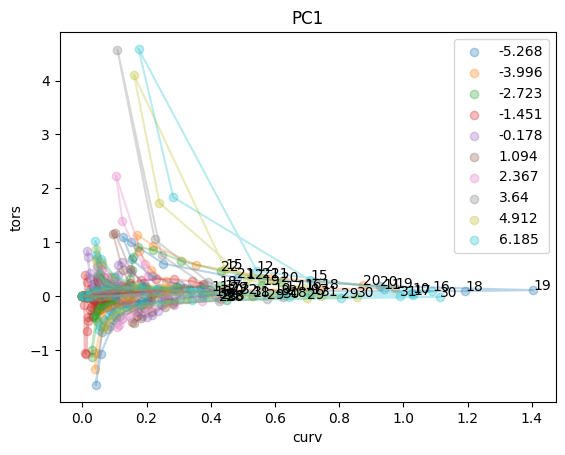

In [66]:
for i in range(10): 
    pc1filename = pc1files[i].split('\\')[-1]
    pc1_val = pc1filename[8:-4]
    plt.scatter(pc1_curvs[i], pc1_torss[i], label="{}".format(pc1_val), alpha=0.3)
    plt.plot(pc1_curvs[i], pc1_torss[i], alpha=0.3)
    for j in range(len(pc1_curvs[i])):
        if pc1_curvs[i][j] > 0.4:
            plt.text(x=pc1_curvs[i][j], y=pc1_torss[i][j], s=j)

plt.xlabel("curv")
plt.ylabel("tors")
plt.title("PC1")
plt.legend()

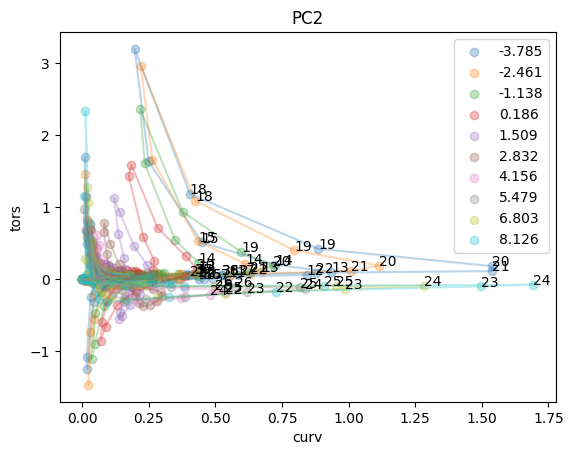

In [67]:
for i in range(10): 
    pc2filename = pc2files[i].split('\\')[-1]
    pc2_val = pc2filename[8:-4]
    plt.scatter(pc2_curvs[i], pc2_torss[i], label="{}".format(pc2_val), alpha=0.3)
    plt.plot(pc2_curvs[i], pc2_torss[i], alpha=0.3)
    for j in range(len(pc2_curvs[i])):
        if pc2_curvs[i][j] > 0.4:
            plt.text(x=pc2_curvs[i][j], y=pc2_torss[i][j], s=j)

plt.xlabel("curv")
plt.ylabel("tors")
plt.title("PC2")
plt.legend()

In [82]:
SAVE_SYN=0

xc = (min(tw_result[:,0])+max(tw_result[:,0]))/2.0
yc = (min(tw_result[:,1])+max(tw_result[:,1]))/2.0

print( xc, yc)


def sum_distance(rad):
    d_sum=0
    for i in range(len(tw_result)):
        d_sum =d_sum +  abs(np.linalg.norm([tw_result[i,0]-xc, tw_result[i,1]-yc]) - rad)
    return d_sum


x0=np.float64(5.1)
print (x0)
res = minimize(sum_distance, x0=x0, method='Nelder-Mead')
print (res.x)

circle_dir = mkdir(super_path='D:\\!BraVa_src\\src\\ModeDecomposition\\synthetic_vessels\\',testname='circle')

theta = np.linspace(0, 2 * np.pi, 100)
# Plotting

for i in range(0,100,5):

    fig = plt.figure(figsize=(11,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)
    ax2.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)

    ax2.scatter(xc, yc, color="red", marker="x")
    ax2.scatter(tw_result[:,0], tw_result[:,1], color="dimgray", edgecolors="lightcoral", alpha=0.4)


    ax2.plot(res.x * np.cos(theta)+xc, res.x * np.sin(theta)+yc, color="red", linestyle="--")


    x_current = (res.x * np.cos(theta[i])+xc)[0]
    y_current = (res.x * np.sin(theta[i])+yc)[0]

    ax2.scatter(x_current, y_current,color="red",marker='*', s=50)
    ax2.text(x=x_current, 
             y=y_current,
             s="({}, {})".format(round(x_current, 3), round(y_current, 3)),
             color="black")
    synthetic = np.zeros(10)
    synthetic[0] = x_current
    synthetic[1] = y_current


    syn_circle= tw_pca.inverse_transform(synthetic)
    coords = [syn_circle[:64], Y_geom, Z_geom]
    coords = np.array(coords).T
    coords = (64.0/measure_length(coords))*coords

    ax1.plot(coords[:,0])

    scalarAttribute= [['MaximumInscribedSphereRadius', 'float', np.mean(r,axis=1)]]
    if SAVE_SYN == 1:
        makeVtkFile(savePath=circle_dir + "circle_{:0=3}.vtk".format(i),
                    coords=coords,
                    scalarAttributes=scalarAttribute,
                    fieldAttributes=[])
        print ("made files")
    plt.close(fig)


0.45812506055998403 2.1707368563989857
5.1
[4.77633179]
generating in directory D:\!BraVa_src\src\ModeDecomposition\synthetic_vessels\circle\...
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files
made files


In [84]:
files_cc = sorted(glob.glob(circle_dir+"*.vtk"))
curv_fig_dir = mkdir(super_path=circle_dir, testname="curvature")

for i in range((len(files_cc))):
    fig = plt.figure(figsize=(11,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)
    ax2.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.2)

    ax2.scatter(xc, yc, color="darkgray", marker="x")
    # ax2.scatter(tw_result[:,0], tw_result[:,1], color="dimgray")
    for j in tw_u_labels:
        plt.scatter(tw_result[tw_label == j , 0] , tw_result[tw_label == j , 1] , label = j, alpha=0.3)
    # plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')


    ax2.plot(res.x * np.cos(theta)+xc, res.x * np.sin(theta)+yc, color="darkgray", linestyle="--")
    x_current = (res.x * np.cos(theta[i*5])+xc)[0]
    y_current = (res.x * np.sin(theta[i*5])+yc)[0]

    ax2.scatter(x_current, y_current,color="red",marker='^', s=50)
    ax2.text(x=x_current-2.2, 
             y=y_current+0.35,
             s="({}, {})".format(round(x_current, 3), round(y_current, 3)),
             color="red")


    
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(files_cc[i])
    print (pt.shape, Curv.shape,  Abscissas.shape)
    #if i!=0:
        #_, Curv_previous, _, _, Abscissas_previous, _ = GetMyVtk(files_cc[i-1])
        # ax2.scatter(synthetic_2[i-1,0], synthetic_2[i-1,1], marker="^", label="synth", color="purple")
        # ax1.plot(Abscissas_previous, Curv_previous, label="{}".format(pc2_val), color="purple",marker=".", alpha=0.3)
    #if i<len(files_cc)-1:
        #_, Curv_next, _, _, Abscissas_next, _ = GetMyVtk(files_cc[i+1])
        #ax2.scatter(synthetic_2[i+1,0], synthetic_2[i+1,1], marker="^", label="synth", color="orange")
        #ax1.plot(Abscissas_next, Curv_next, label="{}".format(pc2_val), color="orange",marker=".", alpha=0.3)
    # ax1.plot(Abscissas, Curv, color="red",marker=".")
    ax1.plot(Abscissas, Curv, color="red",marker=".")
    ax1.set_ylim([0,1.5])
    ax1.set_ylabel("curvature")
    ax1.set_xlabel("abscissas")
    ax11=ax1.twinx()
    ax11.set_ylim([-30,30])
    ax11.set_ylabel("x position")
    ax11.plot(Abscissas, pt[:,0], color="gray", linewidth=10, alpha=0.2)
    ax11.plot(np.mean(abscs, axis=0), pca_mean[:,0], color="gray", linewidth=3, alpha=0.6, linestyle=":")
    ax2.scatter(x_current, y_current, marker="^", label="synth", color="red", s=40)


    plt.tight_layout()
    plt.savefig(curv_fig_dir+"{:0=3}.png".format(i))
    plt.close(fig)



filespc = sorted(glob.glob(curv_fig_dir+"*.png"))
print (len(filespc))
# font = ImageFont.truetype("Gidole-Regular.ttf", size=25)

imgs = []
j = 0
for i in range(len(filespc)):
    im = Image.open(filespc[i])
    draw = ImageDraw.Draw(im)
    imgs.append(im)
print (len(imgs))

imgs[0].save(curv_fig_dir+ 'pillow_imagedraw.gif',
               save_all=True, append_images=imgs[1:], optimize=False, duration=1000, loop=0)




generating in directory D:\!BraVa_src\src\ModeDecomposition\synthetic_vessels\circle\curvature\...
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
(64, 3) (64,) (64,)
20
20


# 